# Objectif

L'objectif de se notebook est d'analyser les resultats des réponses données dans notre questionnaire, de les viusaliser sous forme de graphiques, et de confirmer (ou non) leur validité statistique.

Ceci est fait dans le but de définir (dans la conclusion) si notre idée d'application aurait de la demande, si oui avec quelles fonctionnalitées, ainsi que le profil type des utilisateurs.

Link to the initial survey : https://forms.gle/pHLXZbEDPjVPqWXo7

# Set up

## **Import**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')
nltk.download('punkt')
from tabulate import tabulate
from IPython.display import HTML

pd.set_option('display.max_colwidth', None)
sns.set_theme()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
sheet_id = '1M8iF1uEIq87eqKuAzGS3L78_actgOsIqgvnHU3ietoo'
df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

## **Nombre de participants**

In [5]:
#@title
ans_cnt = len(df)
print(ans_cnt)

971


## **Données manquantes**

In [7]:
#@title
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False).reset_index().rename(columns={'index': 'question'})
missing_value_df

,question,percent_missing
0,Souhaitez-vous partager avec nous des problèmes que vous rencontrez et qui sont associés aux jeux vidéo ?,79.402678
1,"Si vous avez répondu oui, pourriez-vous nous expliquer ce qui vous frustre ?",68.692070
2,"Si vous avez répondu non, souhaitez-vous partager en ligne du contenu gaming ?",24.201854
3,Quel(s) service(s) utilisez-vous pour partager du contenu gaming ?,14.727085
4,"Si vous avez répondu oui, que faîtes-vous pour vous améliorer ?",10.813594
5,"Comment avez-vous trouvé ce questionnaire ? (Nom de page facebook, bouche-à-oreille, ...)",7.929969
6,Quels sont les services que vous utilisez pour rencontrer d'autres joueurs ?,3.398558
7,Vous sentez-vous frustré par le matchmaking dans les jeux compétitifs ?,2.162719
8,Vous arrive-t-il de n'avoir personne avec qui jouer ?,1.544799
9,À quel point êtes-vous compétitif lorsque vous jouez à des jeux vidéo ?,1.338826


## **Data preparation**

In [8]:
df.rename(columns={
    'Quel est votre sexe ?': 'gender',
    'Quel âge avez-vous ?': 'age',
    'Quelle est votre situation professionnelle ?': 'employment',
    'Quel est le plus haut niveau de scolarité que vous avez atteint ?': 'education',
    'Comment avez-vous trouvé ce questionnaire ? (Nom de page facebook, bouche-à-oreille, ...)': 'survey_source',
    'À quelle fréquence jouez-vous aux jeux vidéo ?': 'play_frequency',
    'Listez les appareils sur lesquels vous jouez aux jeux vidéo': 'gaming_devices',
    'Préférez-vous jouer à des jeux solo, des jeux multiplayer ou les deux ?': 'solo_mult_preference',
    'Avec qui jouez-vous à des jeux multiplayer ?': 'friends_vs_random_gaming',
    'Quelles sont vos catégories de jeux préférées ?': 'genres_preference',
    "Vous arrive-t'il souvent de chercher des joueurs avec qui jouer en dehors de votre cercle d'amis ?": 'play_outside_friend_group',
    "Quels sont les services que vous utilisez pour rencontrer d'autres joueurs ?": 'service_meet_gamers',
    "Vous arrive-t-il de n'avoir personne avec qui jouer ?": 'no_one_play_with',
    "Vous est-il déjà arrivé d'utiliser un service pour trouver des joueurs avec qui jouer ?": 'use_service_lfp',
    "Essayez-vous activement d'améliorer votre niveau de jeu dans les jeux vidéo ?": 'improve_gaming',
    "Souhaitez-vous partager avec nous des problèmes que vous rencontrez et qui sont associés aux jeux vidéo ?  ": 'problems_gamers',
    "Avez-vous déjà dépensé de l'argent afin de vous améliorer dans un jeu vidéo ou bien recevoir de l'aide d'un autre joueur ?": 'spend_money',
    "Partagez-vous en ligne du contenu associé aux jeux vidéo ?": 'share_content',
    "Jouez-vous à des jeux vidéo compétitifs ?": 'competitiveness',
    "Quelles sont vos catégories de jeux préférées ?" : 'game_types'
}, inplace=True)

# Variable pour le nom de chaque feature
age_bins = 'age_bins'
gender = 'gender'
age = 'age'
employment = 'employment'
education = 'education'
survey_source = 'survey_source'
play_outside_friend_group = 'play_outside_friend_group'
gaming_devices = 'gaming_devices'
use_service_lfp = 'use_service_lfp'
play_frequency = 'play_frequency'
problems_gamers = 'problems_gamers'
improve_gaming = 'improve_gaming'
spend_money = 'spend_money'
share_content = 'share_content'
competitiveness = 'competitiveness'
game_types = 'game_types'

df = df[df['age'] < 100]
df['survey_source'] = df['survey_source'].fillna('None')

# Création de tranches d'âge
bins = [0, 13, 18, 24, 34, 54, 100]
df['age_bins'] = pd.cut(df['age'], bins, labels=["0-13", "13-18", "19-24", "25-34", "35-54", '55+'])
df[age_bins] = df[age_bins].astype('category')

# Création de booléens pour les devices
df['play_pc'] = df['gaming_devices'].apply(lambda x: 1 if 'PC' in str(x) else 0) 
df['play_ps4'] = df['gaming_devices'].apply(lambda x: 1 if 'PS4' in str(x) else 0) 
df['play_xbox'] = df['gaming_devices'].apply(lambda x: 1 if 'Xbox One' in str(x) else 0)
df['play_switch'] = df['gaming_devices'].apply(lambda x: 1 if 'Nintendo Switch' in str(x) else 0)  
df['play_smartphone'] = df['gaming_devices'].apply(lambda x: 1 if 'Téléphone portable' in str(x) else 0) 
df['play_tablet'] = df['gaming_devices'].apply(lambda x: 1 if 'Tablette' in str(x) else 0) 


In [1]:
#Defining function for statiscal significance (chi square testing)
def stat_test_chi2(df, feature1, feature2, alpha):
  """ Test the independence between two features using the chi-square statistical test"""
  data_crosstab = pd.crosstab(df[feature2], df[feature1], margins = False)
  stat, p, dof, expected = chi2_contingency(data_crosstab)
  print(tabulate(data_crosstab, headers='keys', tablefmt='psql'), '\n')
    
  # interpret p-value 
  alpha = alpha #confidence level for hypothesis
  print("p value is " + str(round(p, 6))+'\n') 
  if p <= alpha: 
      print('Conclusion: Dependent (reject H0)\n') 
  else: 
      print('Conclusion: Independent (H0 holds true)') 

# **Source du questionnaire**

Comment avez-vous trouvé ce questionnaire ? (Nom de page facebook, bouche-à-oreille, ...)


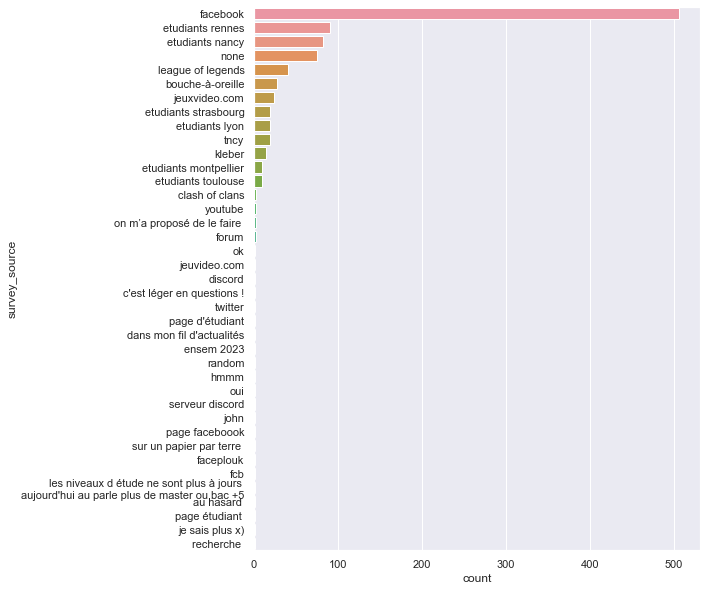

In [10]:
#@title
df[survey_source] = df[survey_source].str.lower().replace('fb', 'Facebook')

df.loc[df[survey_source].str.contains('lol', case=False), survey_source] = 'league of legends'
df.loc[df[survey_source].str.contains('league', case=False), survey_source] = 'league of legends'
df.loc[df[survey_source].str.contains('tncy', case=False), survey_source] = 'tncy'
df.loc[df[survey_source].str.contains('tn', case=False), survey_source] = 'tncy'
df.loc[df[survey_source].str.contains('nancy', case=False), survey_source] = 'etudiants nancy'
df.loc[df[survey_source].str.contains('renn', case=False), survey_source] = 'etudiants rennes'
df.loc[df[survey_source].str.contains('montp', case=False), survey_source] = 'etudiants montpellier'
df.loc[df[survey_source].str.contains('mtp', case=False), survey_source] = 'etudiants montpellier'
df.loc[df[survey_source].str.contains('stras', case=False), survey_source] = 'etudiants strasbourg'
df.loc[df[survey_source].str.contains('toulous', case=False), survey_source] = 'etudiants toulouse'
df.loc[df[survey_source].str.contains('lyon', case=False), survey_source] = 'etudiants lyon'
df.loc[df[survey_source].str.contains('clash', case=False), survey_source] = 'clash of clans'
df.loc[df[survey_source].str.contains('aps', case=False), survey_source] = 'kleber'
df.loc[df[survey_source].str.contains('kleber', case=False), survey_source] = 'kleber'
df.loc[df[survey_source].str.contains('youtube', case=False), survey_source] = 'youtube'
df.loc[df[survey_source].str.contains('partag', case=False), survey_source] = 'bouche-à-oreille'
df.loc[df[survey_source].str.contains('ami', case=False), survey_source] = 'bouche-à-oreille'
df.loc[df[survey_source].str.contains('bouch', case=False), survey_source] = 'bouche-à-oreille'
df.loc[df[survey_source].str.contains('matta', case=False), survey_source] = 'tncy'
df.loc[df[survey_source].str.contains('jv', case=False), survey_source] = 'jeuxvideo.com'
df.loc[df[survey_source].str.contains('jeux', case=False), survey_source] = 'jeuxvideo.com'
df.loc[df[survey_source].str.contains('fb', case=False), survey_source] = 'facebook'
df.loc[df[survey_source].str.contains('facebook', case=False), survey_source] = 'facebook'
df.loc[df[survey_source].str.contains('groupe', case=False), survey_source] = 'facebook'

plt.figure(figsize=(8,10))
sns.countplot(y=df[survey_source], order=df[survey_source].value_counts().index);

# **Démographie**

## **Sexe**

Quel est votre sexe ?

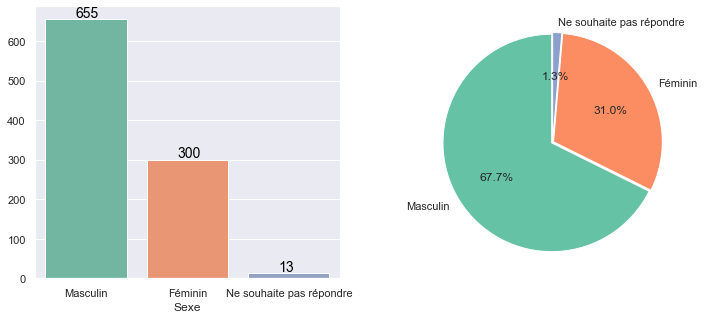

In [11]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df[gender], palette='Set2', ax=ax[0]);
for i, v in enumerate(df.groupby(gender).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(i-0.10 , v+5 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Sexe');
ax[0].set_ylabel('');

labels = df[gender].unique().tolist()
sizes = df[gender].value_counts().values.tolist()

explode = (0.01, 0.01, 0.01)

colors = ['#66c2a5','#fc8d62','#8da0cb']
ax[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

## **Age**

Quel âge avez-vous ?

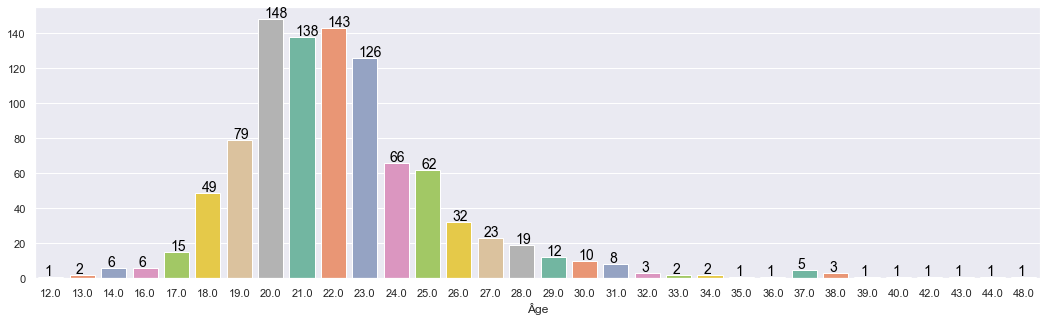

In [12]:
#@title
plt.figure(figsize=(18, 5))

sns.countplot(x=df[age], palette='Set2');
for i, v in enumerate(df.groupby(age).count().reset_index()['Timestamp']):
    plt.text(i-0.2 , v+1 , str(f"{int(v):,}"), color='black', size=14);

plt.xlabel('Âge');
plt.ylabel('');

## **Situation professionnelle**

Quelle est votre situation professionnelle ?

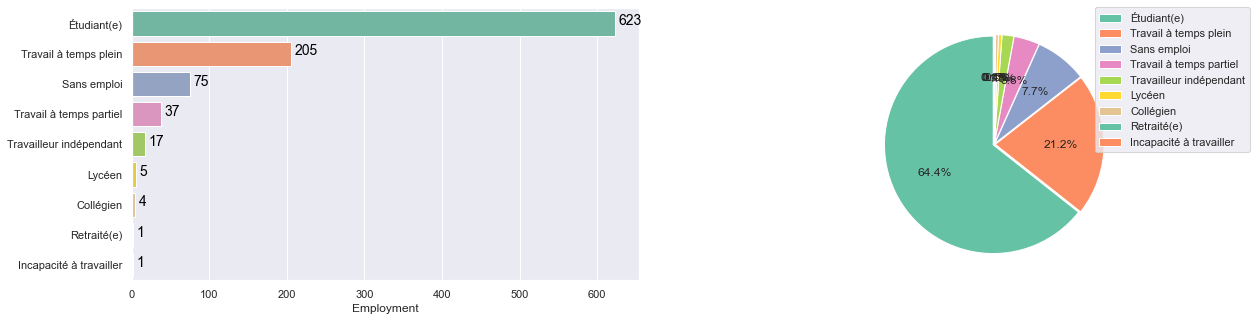

In [13]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(y=df[employment], palette='Set2', order=df[employment].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(employment).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Employment');
ax[0].set_ylabel('');


labels = df[employment].value_counts().index.tolist()
sizes = df[employment].value_counts().values.tolist()

explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)

colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

## **Éducation**

Quel est le plus haut niveau de scolarité que vous avez atteint ?

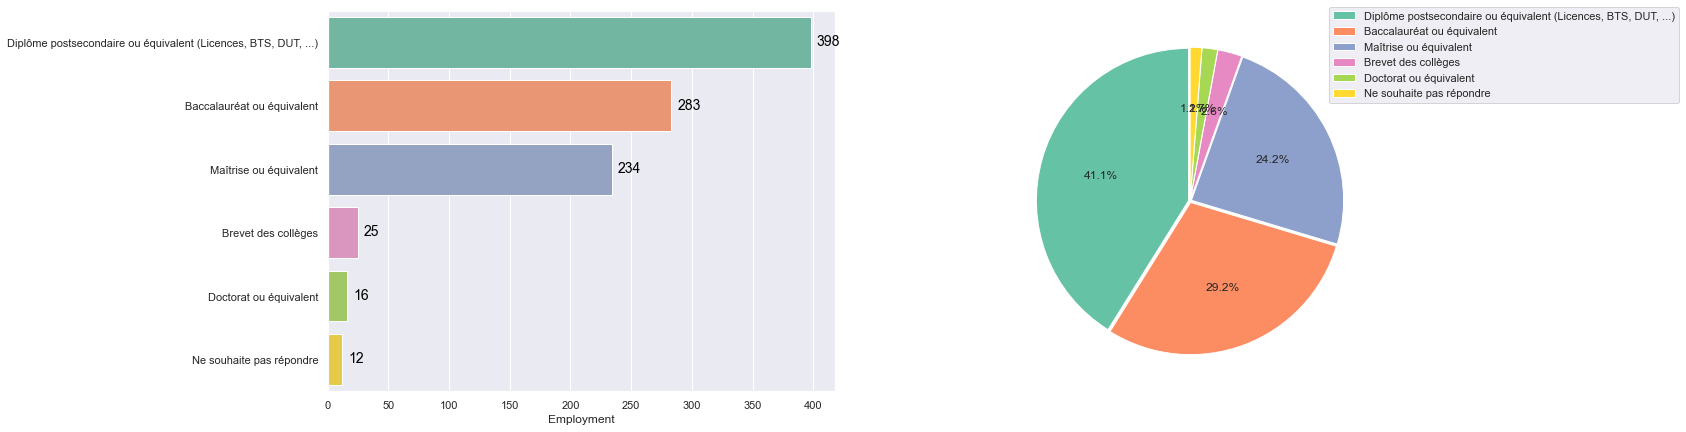

In [14]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.countplot(y=df[education], palette='Set2', order=df[education].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(education).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Employment');
ax[0].set_ylabel('');


labels = df[education].value_counts().index.tolist()
sizes = df[education].value_counts().values.tolist()

explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)

colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

# **Social et comportemental**

## **Fréquence de jeu**

À quelle fréquence jouez-vous aux jeux vidéo ?

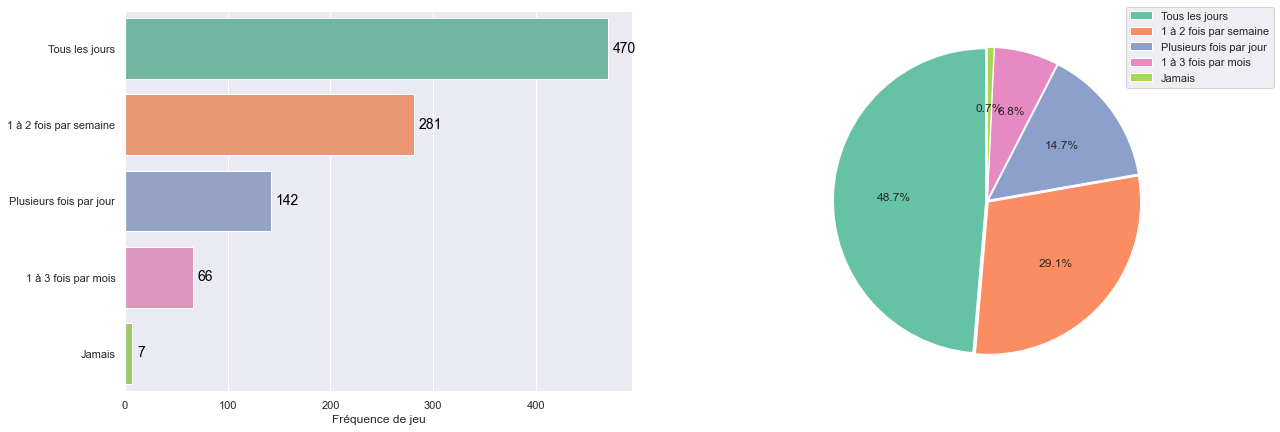

In [15]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.countplot(y=df[play_frequency], palette='Set2', order=df[play_frequency].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(play_frequency).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Fréquence de jeu');
ax[0].set_ylabel('');


labels = df[play_frequency].value_counts().index.tolist()
sizes = df[play_frequency].value_counts().values.tolist()

explode = (0.01, 0.01, 0.01, 0.01, 0.01)

colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

## **Jouer avec des randoms**

Vous arrive-t'il souvent de chercher des joueurs avec qui jouer en dehors de votre cercle d'amis ?

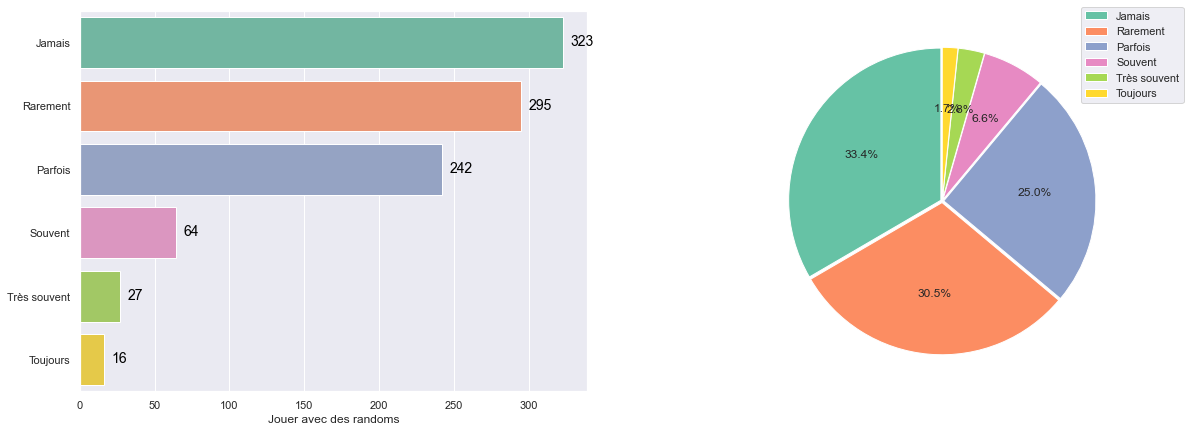

In [16]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.countplot(y=df[play_outside_friend_group], palette='Set2', order=df[play_outside_friend_group].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(play_outside_friend_group).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Jouer avec des randoms');
ax[0].set_ylabel('');


labels = df[play_outside_friend_group].value_counts().index.tolist()
sizes = df[play_outside_friend_group].value_counts().values.tolist()

explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)

colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

### Par sexe

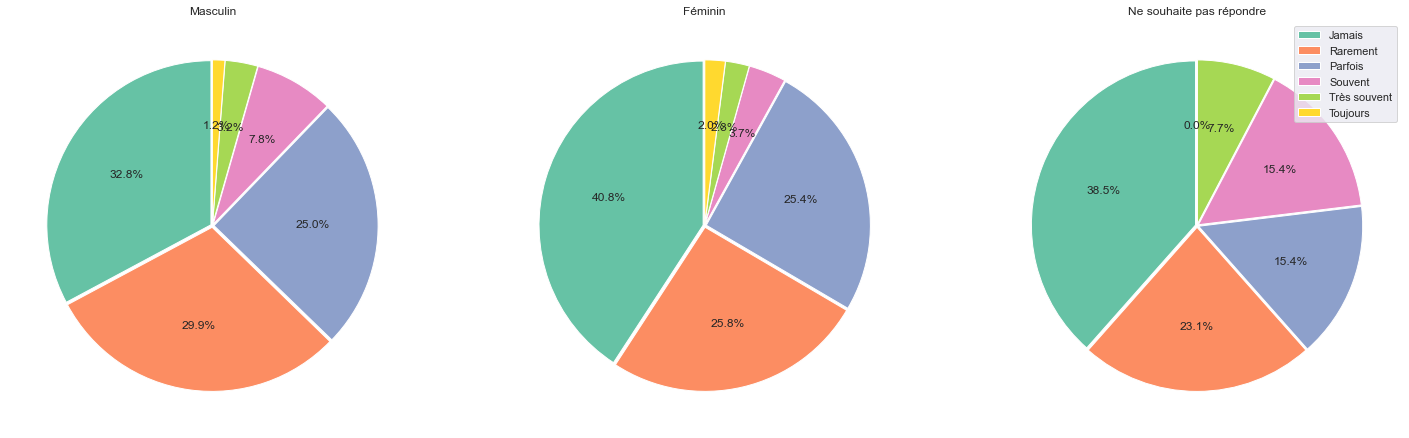

In [17]:
#@title
fig, ax = plt.subplots(1, 3, figsize=(25, 15))

df[play_outside_friend_group] = df[play_outside_friend_group].astype('category')

dct = {'Masculin': 0, 'Féminin': 1, 'Ne souhaite pas répondre': 2}

labels = df[play_outside_friend_group].dropna().value_counts().index.tolist()
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

for gend in df[gender].unique().tolist():
  sizes = df[df[gender]== gend][play_outside_friend_group].value_counts().tolist()

  ax[dct[gend]].set_title(gend)
  ax[dct[gend]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[2].legend(labels, loc='upper right');

In [18]:
#@title
print('Hypothesis (H0): no relation between gender and playing with randoms\n')
stat_test_chi2(df[~(df[gender] == 'Ne souhaite pas répondre')], gender, play_outside_friend_group, 0.05)

Hypothesis (H0): no relation between gender and playing with randoms

+-----------------------------+-----------+------------+
| play_outside_friend_group   |   Féminin |   Masculin |
|-----------------------------+-----------+------------|
| Jamais                      |       122 |        196 |
| Parfois                     |        76 |        164 |
| Rarement                    |        77 |        215 |
| Souvent                     |        11 |         51 |
| Toujours                    |         7 |          8 |
| Très souvent                |         6 |         21 |
+-----------------------------+-----------+------------+ 

p value is 0.002219

Conclusion: Dependent (reject H0)



### Par tranche d'âge

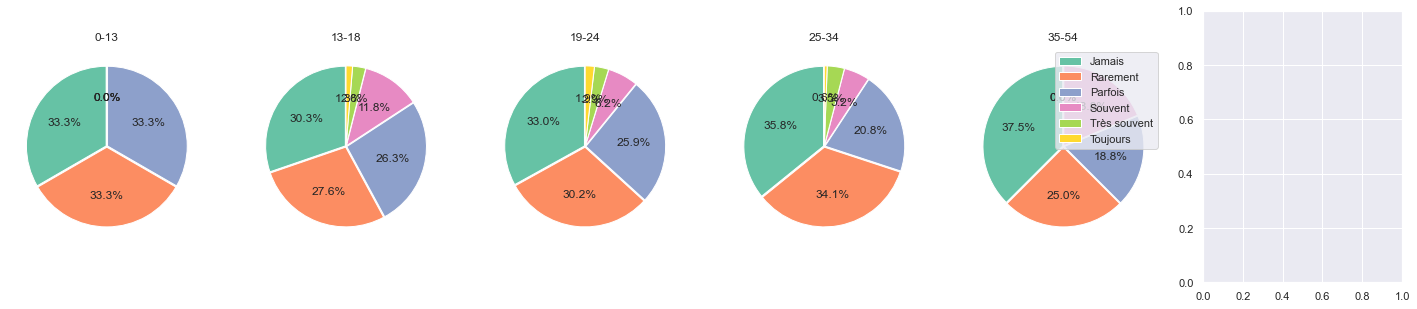

In [19]:
#@title
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

dct = {'0-13': 0, '13-18': 1, '19-24': 2, '25-34': 3, '35-54': 4, '55+': 5}

labels = df[play_outside_friend_group].dropna().value_counts().index.tolist()
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

for age_bin in df[age_bins].unique().tolist():
  sizes = df[df[age_bins]== age_bin][play_outside_friend_group].value_counts().tolist()

  ax[dct[age_bin]].set_title(age_bin)
  ax[dct[age_bin]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [20]:
#@title
print('Hypothesis (H0): no relation between age and playing with randoms\n')
stat_test_chi2(df, age_bins, play_outside_friend_group, 0.05)

Hypothesis (H0): no relation between age and playing with randoms

+-----------------------------+--------+---------+---------+---------+---------+
| play_outside_friend_group   |   0-13 |   13-18 |   19-24 |   25-34 |   35-54 |
|-----------------------------+--------+---------+---------+---------+---------|
| Jamais                      |      1 |      23 |     231 |      62 |       6 |
| Parfois                     |      1 |      21 |     181 |      36 |       3 |
| Rarement                    |      1 |      20 |     211 |      59 |       4 |
| Souvent                     |      0 |       9 |      43 |       9 |       3 |
| Toujours                    |      0 |       2 |      13 |       1 |       0 |
| Très souvent                |      0 |       1 |      20 |       6 |       0 |
+-----------------------------+--------+---------+---------+---------+---------+ 

p value is 0.765653

Conclusion: Independent (H0 holds true)


### Par fréquence de jeu

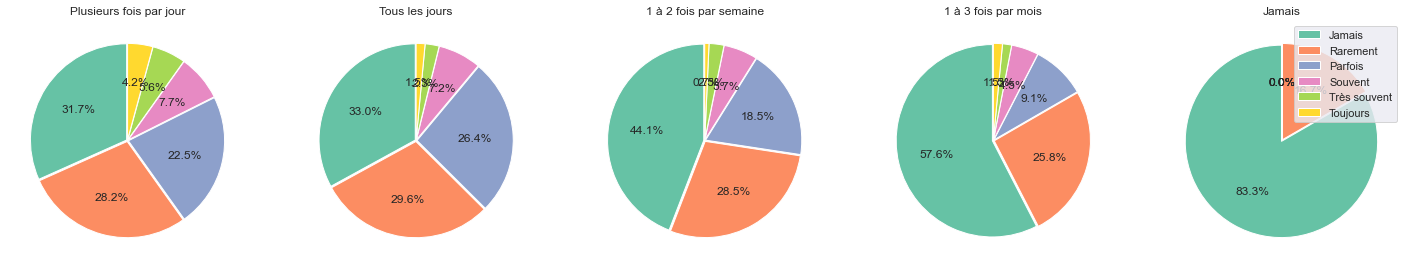

In [21]:
#@title
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

dct = {'Plusieurs fois par jour': 0, 'Tous les jours': 1, '1 à 2 fois par semaine': 2, '1 à 3 fois par mois': 3, 'Jamais': 4}

labels = df[play_outside_friend_group].dropna().value_counts().index.tolist()
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
colors = ['#66c2a5','#fc8d62','#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

for frequency in df[play_frequency].unique().tolist():
  sizes = df[df[play_frequency]== frequency][play_outside_friend_group].value_counts().tolist()

  if frequency in dct.keys():
    ax[dct[frequency]].set_title(frequency)
    ax[dct[frequency]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [22]:
#@title
print('Hypothesis (H0): no relation between gaming frequency and playing with randoms\n')
stat_test_chi2(df, play_frequency, play_outside_friend_group, 0.05)

Hypothesis (H0): no relation between gaming frequency and playing with randoms

+-----------------------------+--------------------------+-----------------------+----------+---------------------------+------------------+
| play_outside_friend_group   |   1 à 2 fois par semaine |   1 à 3 fois par mois |   Jamais |   Plusieurs fois par jour |   Tous les jours |
|-----------------------------+--------------------------+-----------------------+----------+---------------------------+------------------|
| Jamais                      |                      124 |                    38 |        5 |                        32 |              124 |
| Parfois                     |                       52 |                     6 |        0 |                        45 |              139 |
| Rarement                    |                       80 |                    17 |        1 |                        40 |              155 |
| Souvent                     |                       16 |                

## **Chercher des joueurs en ligne**


Vous est-il déjà arrivé d'utiliser un service pour trouver des joueurs avec qui jouer ?

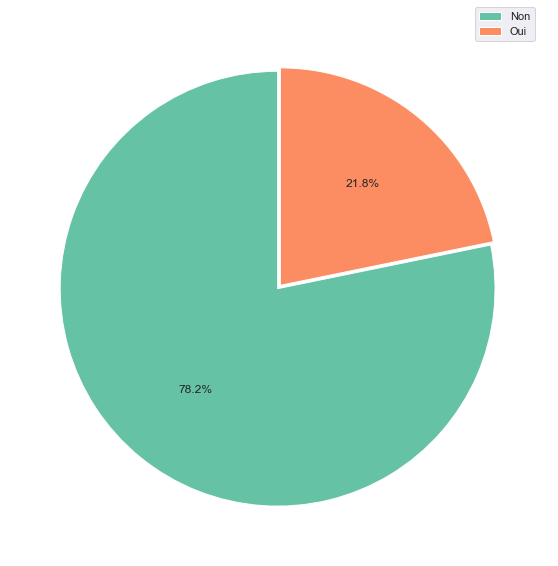

In [23]:
#@title
plt.figure(figsize=(18, 10))

labels = df[use_service_lfp].value_counts().index.tolist()
sizes = df[use_service_lfp].value_counts().values.tolist()

explode = (0.01, 0.01)

colors = ['#66c2a5','#fc8d62']
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

plt.legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

### Par sexe

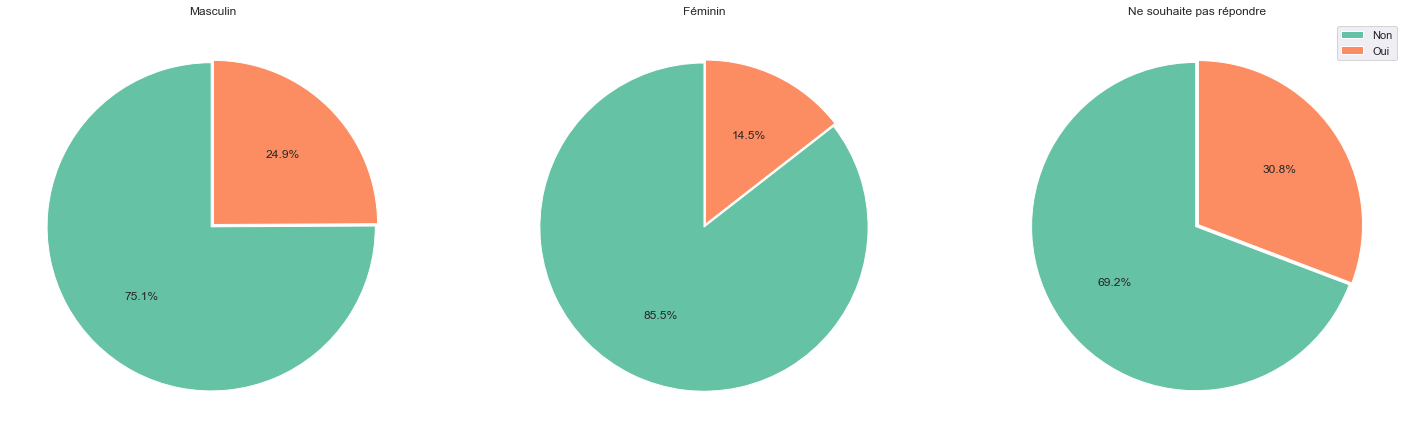

In [24]:
#@title
fig, ax = plt.subplots(1, 3, figsize=(25, 15))

df[use_service_lfp] = df[use_service_lfp].astype('category')

dct = {'Masculin': 0, 'Féminin': 1, 'Ne souhaite pas répondre': 2}

labels = df[use_service_lfp].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for gend in df[gender].unique().tolist():
  sizes = df[df[gender]== gend][use_service_lfp].value_counts().tolist()

  ax[dct[gend]].set_title(gend)
  ax[dct[gend]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[2].legend(labels, loc='upper right');

In [25]:
#@title
print('Hypothesis (H0): no relation between gender and using services to get people to play with\n')
stat_test_chi2(df[~(df[gender] == 'Ne souhaite pas répondre')], gender, use_service_lfp, 0.05)

Hypothesis (H0): no relation between gender and using services to get people to play with

+-------------------+-----------+------------+
| use_service_lfp   |   Féminin |   Masculin |
|-------------------+-----------+------------|
| Non               |       254 |        491 |
| Oui               |        43 |        163 |
+-------------------+-----------+------------+ 

p value is 0.000402

Conclusion: Dependent (reject H0)



### Par tranche d'âge

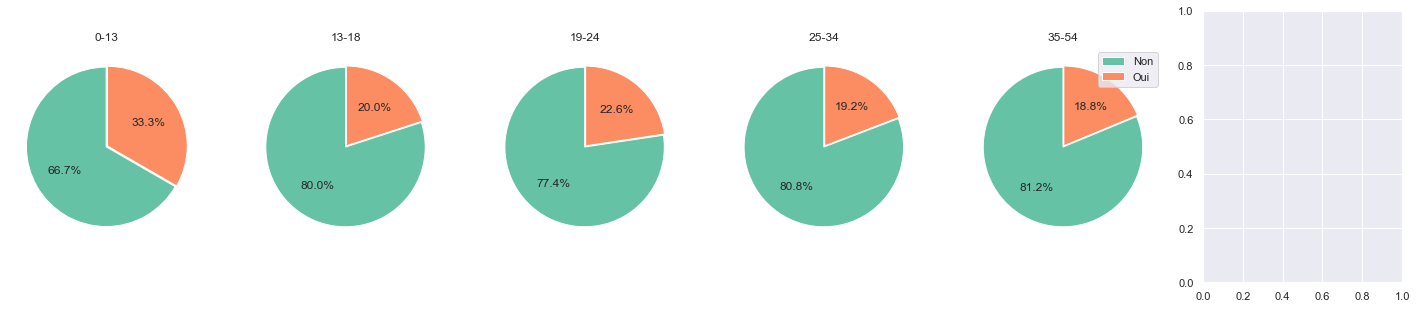

In [26]:
#@title
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

dct = {'0-13': 0, '13-18': 1, '19-24': 2, '25-34': 3, '35-54': 4, '55+': 5}

labels = df[use_service_lfp].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for age_bin in df[age_bins].unique().tolist():
  sizes = df[df[age_bins]== age_bin][use_service_lfp].value_counts().tolist()

  ax[dct[age_bin]].set_title(age_bin)
  ax[dct[age_bin]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [27]:
#@title
print('Hypothesis (H0): no relation between age and using services to get people to play with\n')
stat_test_chi2(df[df['age_bins'].isin(['13-18', '19-24', '25-34'])], age_bins, use_service_lfp, 0.05)

Hypothesis (H0): no relation between age and using services to get people to play with

+-------------------+---------+---------+---------+
| use_service_lfp   |   13-18 |   19-24 |   25-34 |
|-------------------+---------+---------+---------|
| Non               |      60 |     540 |     139 |
| Oui               |      15 |     158 |      33 |
+-------------------+---------+---------+---------+ 

p value is 0.571726

Conclusion: Independent (H0 holds true)


### Par fréquence de jeu

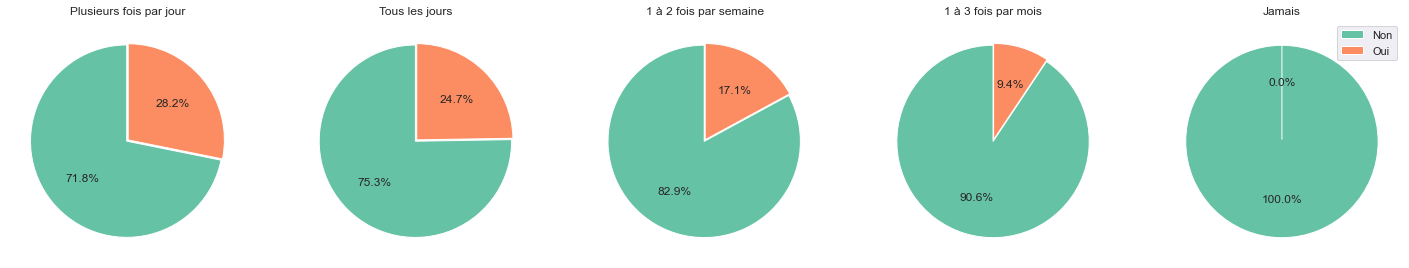

In [28]:
#@title
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

dct = {'Plusieurs fois par jour': 0, 'Tous les jours': 1, '1 à 2 fois par semaine': 2, '1 à 3 fois par mois': 3, 'Jamais': 4}

labels = df[use_service_lfp].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for frequency in df[play_frequency].unique().tolist():
  sizes = df[df[play_frequency]== frequency][use_service_lfp].value_counts().tolist()

  if frequency in dct.keys():
    ax[dct[frequency]].set_title(frequency)
    ax[dct[frequency]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [29]:
#@title
print('Hypothesis (H0): no relation between gaming frequency and using services to get people to play with\n')
stat_test_chi2(df, play_frequency, use_service_lfp, 0.05)

Hypothesis (H0): no relation between gaming frequency and using services to get people to play with

+-------------------+--------------------------+-----------------------+----------+---------------------------+------------------+
| use_service_lfp   |   1 à 2 fois par semaine |   1 à 3 fois par mois |   Jamais |   Plusieurs fois par jour |   Tous les jours |
|-------------------+--------------------------+-----------------------+----------+---------------------------+------------------|
| Non               |                      233 |                    58 |        6 |                       102 |              353 |
| Oui               |                       48 |                     6 |        0 |                        40 |              116 |
+-------------------+--------------------------+-----------------------+----------+---------------------------+------------------+ 

p value is 0.002051

Conclusion: Dependent (reject H0)



### Par compétitivité des joueurs



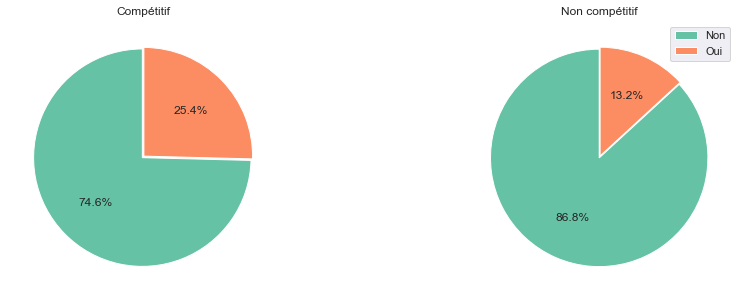

In [30]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

dct = {'Oui': 0, 'Non': 1}
labels = df[use_service_lfp].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for comp in df[competitiveness].dropna().unique().tolist():
  sizes = df[df[competitiveness]== comp][use_service_lfp].value_counts().tolist()

  if comp in dct.keys():
    if comp == 'Oui':
      ax[dct[comp]].set_title('Compétitif')
      ax[dct[comp]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
          shadow=False, startangle=90);
    else:
      ax[dct[comp]].set_title('Non compétitif')
      ax[dct[comp]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
          shadow=False, startangle=90);

ax[1].legend(labels, loc='upper right');

In [31]:
#@title
print('Hypothesis (H0): no relation between competitiveness and using services to get people to play with\n')
stat_test_chi2(df, competitiveness, use_service_lfp, 0.05)

Hypothesis (H0): no relation between competitiveness and using services to get people to play with

+-------------------+-------+-------+
| use_service_lfp   |   Non |   Oui |
|-------------------+-------+-------|
| Non               |   244 |   508 |
| Oui               |    37 |   173 |
+-------------------+-------+-------+ 

p value is 4.3e-05

Conclusion: Dependent (reject H0)



## **S'améliorer dans les jeux vidéo**

Essayez-vous activement d'améliorer votre niveau de jeu dans les jeux vidéo ?

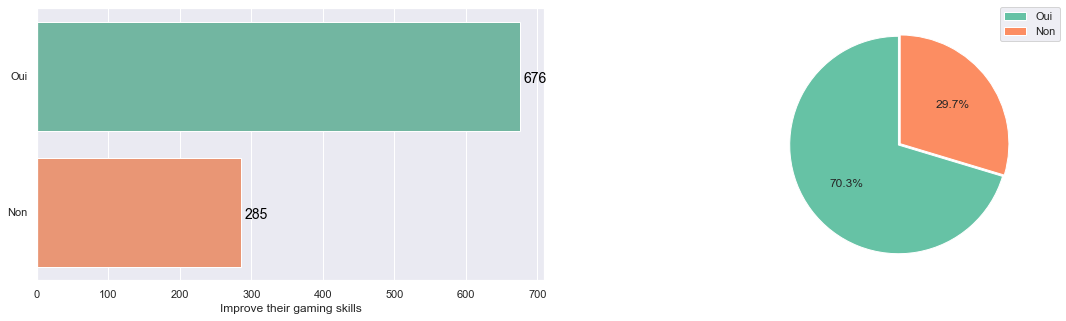

In [32]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(y=df[improve_gaming], palette='Set2', order=df[improve_gaming].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(improve_gaming).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Improve their gaming skills');
ax[0].set_ylabel('');


labels = df[improve_gaming].value_counts().index.tolist()
sizes = df[improve_gaming].value_counts().values.tolist()

explode = (0.01, 0.01)

colors = ['#66c2a5','#fc8d62']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

### Par sexe 

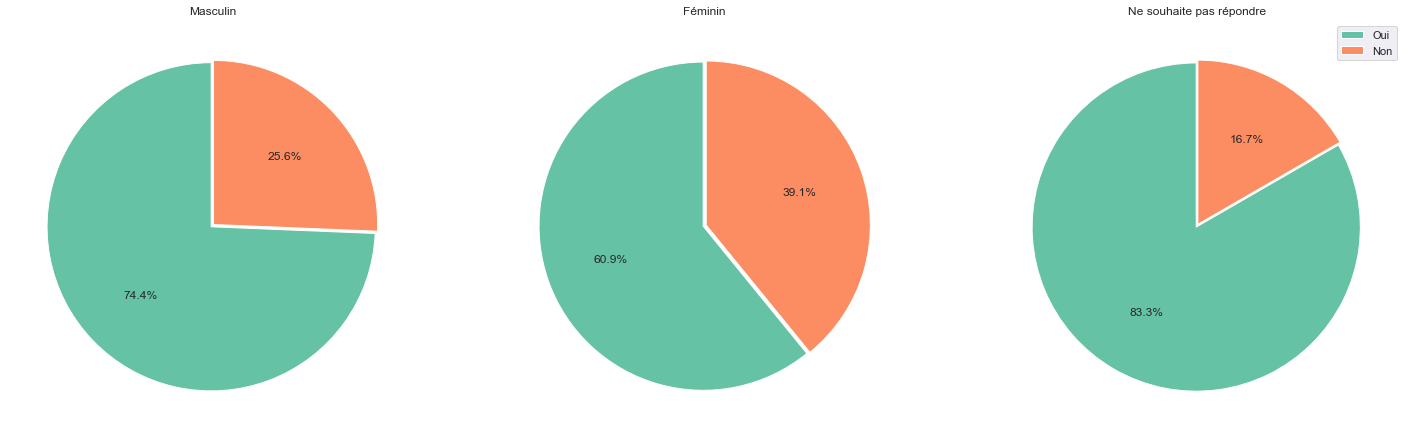

In [33]:
#@title
fig, ax = plt.subplots(1, 3, figsize=(25, 15))

df[improve_gaming] = df[improve_gaming].astype('category')

dct = {'Masculin': 0, 'Féminin': 1, 'Ne souhaite pas répondre': 2}

labels = df[improve_gaming].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for gend in df[gender].unique().tolist():
  sizes = df[df[gender]== gend][improve_gaming].value_counts().tolist()

  ax[dct[gend]].set_title(gend)
  ax[dct[gend]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[2].legend(labels, loc='upper right');

In [34]:
#@title
print('Hypothesis (H0): no relation between gender and wanting to improve at video games\n')
stat_test_chi2(df[~(df[gender] == 'Ne souhaite pas répondre')], gender, improve_gaming, 0.05)

Hypothesis (H0): no relation between gender and wanting to improve at video games

+------------------+-----------+------------+
| improve_gaming   |   Féminin |   Masculin |
|------------------+-----------+------------|
| Non              |       115 |        168 |
| Oui              |       179 |        487 |
+------------------+-----------+------------+ 

p value is 3.8e-05

Conclusion: Dependent (reject H0)



### Par tranche d'âge

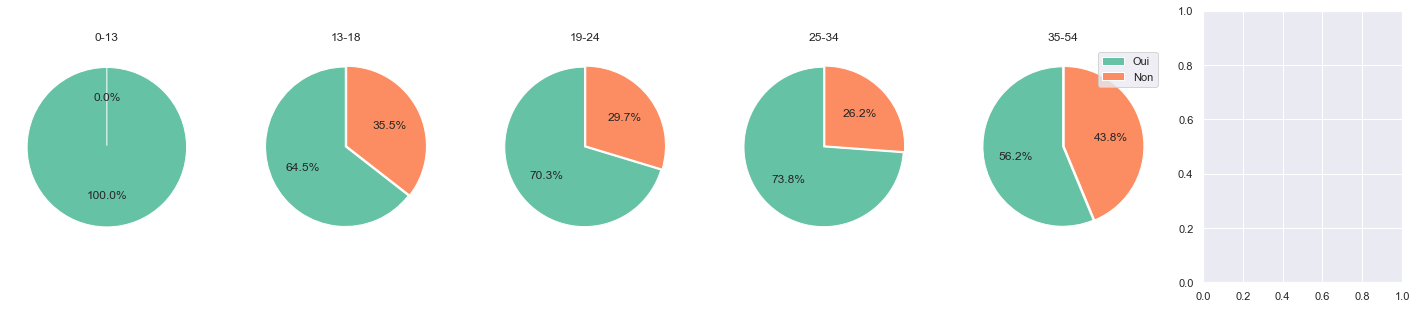

In [35]:
#@title
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

dct = {'0-13': 0, '13-18': 1, '19-24': 2, '25-34': 3, '35-54': 4, '55+': 5}

labels = df[improve_gaming].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for age_bin in df[age_bins].unique().tolist():
  sizes = df[df[age_bins]== age_bin][improve_gaming].value_counts().tolist()

  ax[dct[age_bin]].set_title(age_bin)
  ax[dct[age_bin]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [36]:
#@title
print('Hypothesis (H0): no relation between age and wanting to improve at video games\n')
stat_test_chi2(df, age_bins, improve_gaming, 0.05)

Hypothesis (H0): no relation between age and wanting to improve at video games

+------------------+--------+---------+---------+---------+---------+
| improve_gaming   |   0-13 |   13-18 |   19-24 |   25-34 |   35-54 |
|------------------+--------+---------+---------+---------+---------|
| Non              |      0 |      27 |     206 |      45 |       7 |
| Oui              |      3 |      49 |     488 |     127 |       9 |
+------------------+--------+---------+---------+---------+---------+ 

p value is 0.282206

Conclusion: Independent (H0 holds true)


### Par fréquence de jeu

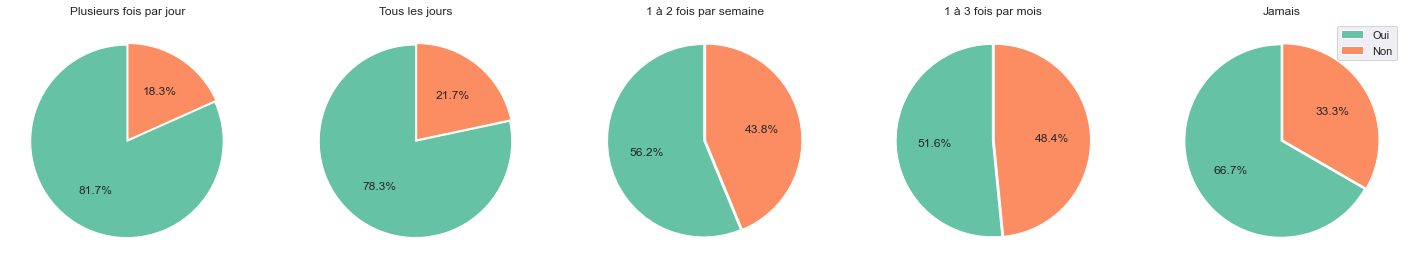

In [37]:
#@title
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

dct = {'Plusieurs fois par jour': 0, 'Tous les jours': 1, '1 à 2 fois par semaine': 2, '1 à 3 fois par mois': 3, 'Jamais': 4}

labels = df[improve_gaming].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for frequency in df[play_frequency].unique().tolist():
  sizes = df[df[play_frequency]== frequency][improve_gaming].value_counts().tolist()

  if frequency in dct.keys():
    ax[dct[frequency]].set_title(frequency)
    ax[dct[frequency]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [38]:
#@title
print('Hypothesis (H0): no relation between gaming frequency and wanting to improve in video games\n')
stat_test_chi2(df, play_frequency, improve_gaming, 0.05)

Hypothesis (H0): no relation between gaming frequency and wanting to improve in video games

+------------------+--------------------------+-----------------------+----------+---------------------------+------------------+
| improve_gaming   |   1 à 2 fois par semaine |   1 à 3 fois par mois |   Jamais |   Plusieurs fois par jour |   Tous les jours |
|------------------+--------------------------+-----------------------+----------+---------------------------+------------------|
| Non              |                      123 |                    31 |        4 |                        26 |              101 |
| Oui              |                      158 |                    33 |        2 |                       116 |              365 |
+------------------+--------------------------+-----------------------+----------+---------------------------+------------------+ 

p value is 0.0

Conclusion: Dependent (reject H0)



## **Dépenser de l'argent pour s'améliorer**

Avez-vous déjà dépensé de l'argent afin de vous améliorer dans un jeu vidéo ou bien recevoir de l'aide d'un autre joueur ?

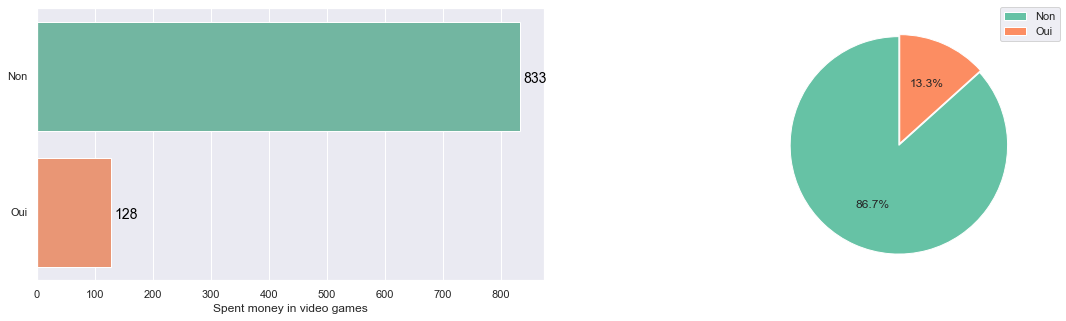

In [39]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(y=df[spend_money], palette='Set2', order=df[spend_money].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(spend_money).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Spent money in video games');
ax[0].set_ylabel('');


labels = df[spend_money].value_counts().index.tolist()
sizes = df[spend_money].value_counts().values.tolist()

explode = (0.01, 0.01)

colors = ['#66c2a5','#fc8d62']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

### Par sexe

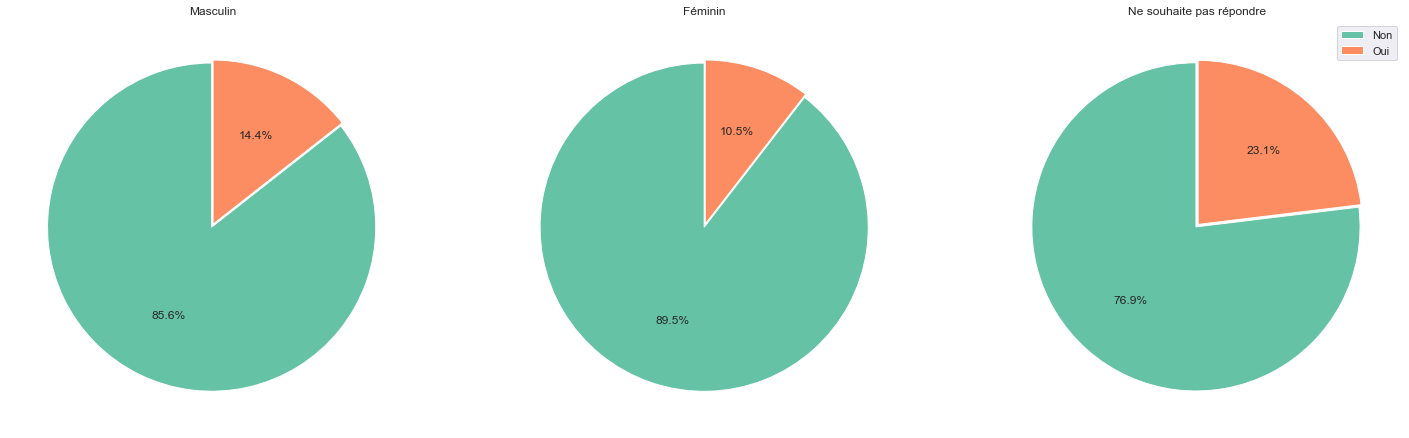

In [40]:
#@title
fig, ax = plt.subplots(1, 3, figsize=(25, 15))

df[spend_money] = df[spend_money].astype('category')

dct = {'Masculin': 0, 'Féminin': 1, 'Ne souhaite pas répondre': 2}

labels = df[spend_money].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for gend in df[gender].unique().tolist():
  sizes = df[df[gender]== gend][spend_money].value_counts().tolist()

  ax[dct[gend]].set_title(gend)
  ax[dct[gend]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[2].legend(labels, loc='upper right');

In [41]:
#@title
print('Hypothesis (H0): no relation between gender and spending money in video games\n')
stat_test_chi2(df[~(df[gender] == 'Ne souhaite pas répondre')], gender, spend_money, 0.05)

Hypothesis (H0): no relation between gender and spending money in video games

+---------------+-----------+------------+
| spend_money   |   Féminin |   Masculin |
|---------------+-----------+------------|
| Non           |       265 |        558 |
| Oui           |        31 |         94 |
+---------------+-----------+------------+ 

p value is 0.118818

Conclusion: Independent (H0 holds true)


### Par tranche d'âge

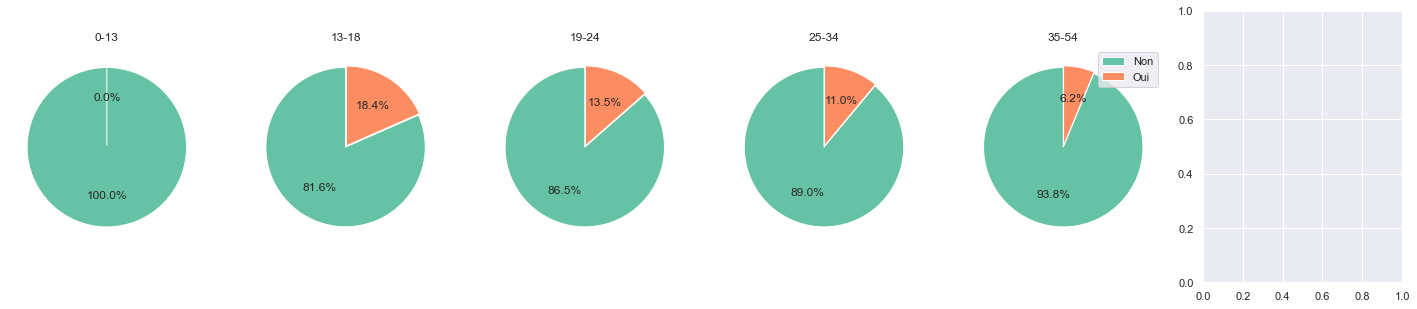

In [42]:
#@title
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

dct = {'0-13': 0, '13-18': 1, '19-24': 2, '25-34': 3, '35-54': 4, '55+': 5}

labels = df[spend_money].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for age_bin in df[age_bins].unique().tolist():
  sizes = df[df[age_bins]== age_bin][spend_money].value_counts().tolist()

  ax[dct[age_bin]].set_title(age_bin)
  ax[dct[age_bin]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [43]:
#@title
print('Hypothesis (H0): no relation between age and spending money IG\n')
stat_test_chi2(df, age_bins, spend_money, 0.05)

Hypothesis (H0): no relation between age and spending money IG

+---------------+--------+---------+---------+---------+---------+
| spend_money   |   0-13 |   13-18 |   19-24 |   25-34 |   35-54 |
|---------------+--------+---------+---------+---------+---------|
| Non           |      3 |      62 |     600 |     153 |      15 |
| Oui           |      0 |      14 |      94 |      19 |       1 |
+---------------+--------+---------+---------+---------+---------+ 

p value is 0.452948

Conclusion: Independent (H0 holds true)


### Par fréquence de jeu

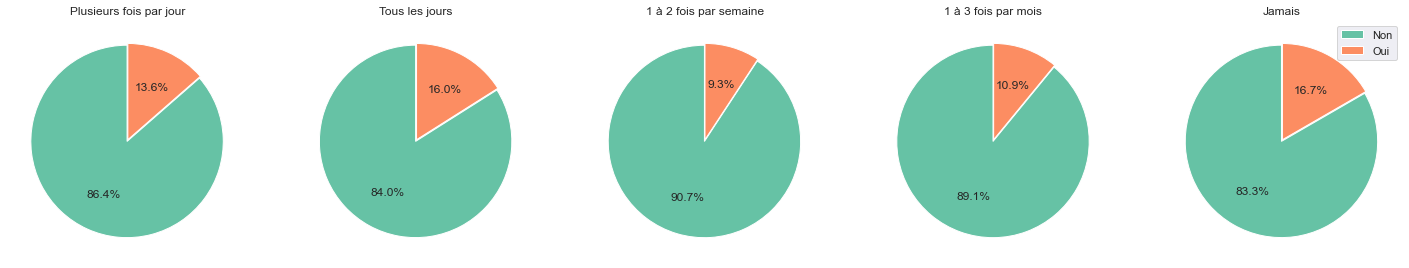

In [44]:
#@title
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

dct = {'Plusieurs fois par jour': 0, 'Tous les jours': 1, '1 à 2 fois par semaine': 2, '1 à 3 fois par mois': 3, 'Jamais': 4}

labels = df[spend_money].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for frequency in df[play_frequency].unique().tolist():
  sizes = df[df[play_frequency]== frequency][spend_money].value_counts().tolist()

  if frequency in dct.keys():
    ax[dct[frequency]].set_title(frequency)
    ax[dct[frequency]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [45]:
#@title
print('Hypothesis (H0): no relation between gaming frequency and spending money IG\n')
stat_test_chi2(df, play_frequency, spend_money, 0.05)

Hypothesis (H0): no relation between gaming frequency and spending money IG

+---------------+--------------------------+-----------------------+----------+---------------------------+------------------+
| spend_money   |   1 à 2 fois par semaine |   1 à 3 fois par mois |   Jamais |   Plusieurs fois par jour |   Tous les jours |
|---------------+--------------------------+-----------------------+----------+---------------------------+------------------|
| Non           |                      255 |                    57 |        5 |                       121 |              393 |
| Oui           |                       26 |                     7 |        1 |                        19 |               75 |
+---------------+--------------------------+-----------------------+----------+---------------------------+------------------+ 

p value is 0.118009

Conclusion: Independent (H0 holds true)


## **Partager du contenu gaming**

Partagez-vous en ligne du contenu associé aux jeux vidéo ?

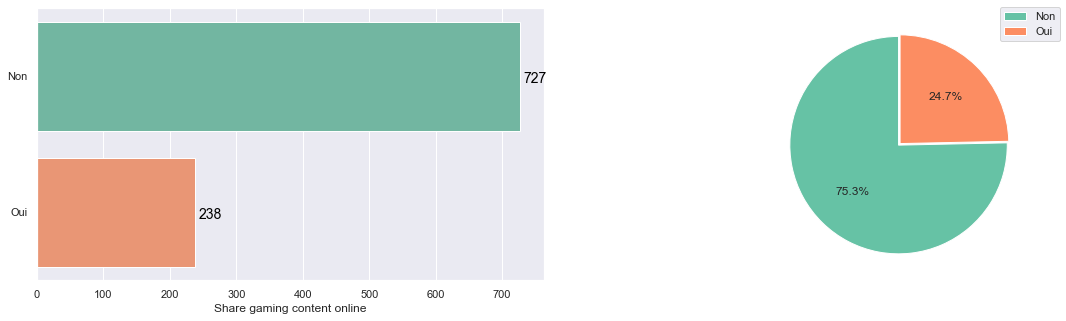

In [46]:
#@title
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(y=df[share_content], palette='Set2', order=df[share_content].value_counts().index, ax=ax[0]);
for i, v in enumerate(df.groupby(share_content).count().reset_index().sort_values('Timestamp', ascending=False)['Timestamp']):
    ax[0].text(v+5, i+0.05 , str(f"{int(v):,}"), color='black', size=14);

ax[0].set_xlabel('Share gaming content online');
ax[0].set_ylabel('');


labels = df[share_content].value_counts().index.tolist()
sizes = df[share_content].value_counts().values.tolist()

explode = (0.01, 0.01)

colors = ['#66c2a5','#fc8d62']
ax[1].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[1].legend(labels, bbox_to_anchor=(0.85,1.025), loc="upper left");

### Par sexe

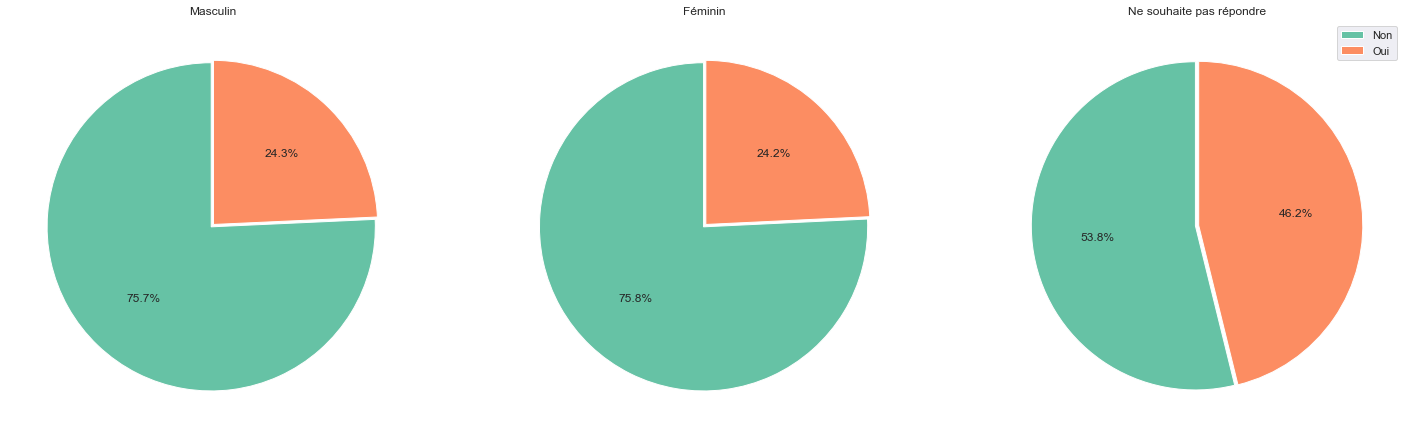

In [47]:
#@title
fig, ax = plt.subplots(1, 3, figsize=(25, 15))

df[share_content] = df[share_content].astype('category')

dct = {'Masculin': 0, 'Féminin': 1, 'Ne souhaite pas répondre': 2}

labels = df[share_content].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for gend in df[gender].unique().tolist():
  sizes = df[df[gender]== gend][share_content].value_counts().tolist()

  ax[dct[gend]].set_title(gend)
  ax[dct[gend]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[2].legend(labels, loc='upper right');

In [48]:
#@title
print('Hypothesis (H0): no relation between gender and sharing gaming content online\n')
stat_test_chi2(df[~(df[gender] == 'Ne souhaite pas répondre')], gender, share_content, 0.05)

Hypothesis (H0): no relation between gender and sharing gaming content online

+-----------------+-----------+------------+
| share_content   |   Féminin |   Masculin |
|-----------------+-----------+------------|
| Non             |       225 |        496 |
| Oui             |        72 |        159 |
+-----------------+-----------+------------+ 

p value is 0.943562

Conclusion: Independent (H0 holds true)


### Par tranche d'âge

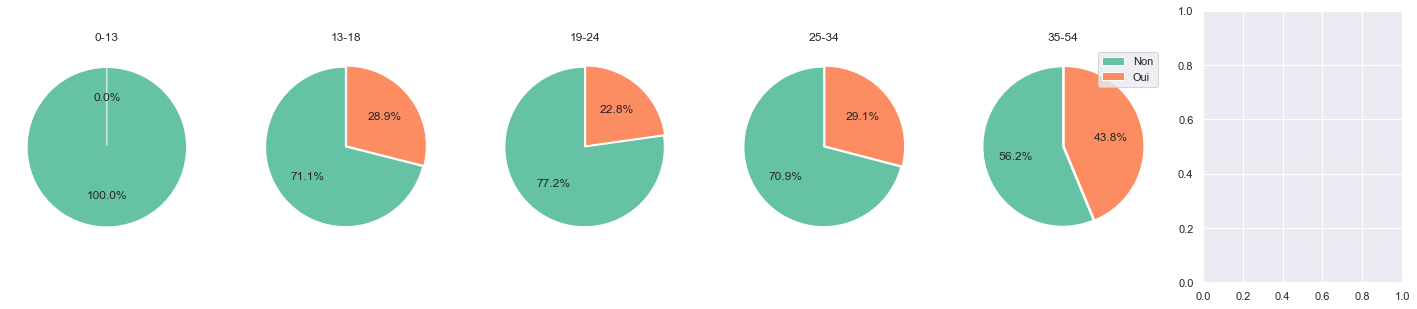

In [49]:
#@title
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

dct = {'0-13': 0, '13-18': 1, '19-24': 2, '25-34': 3, '35-54': 4, '55+': 5}

labels = df[share_content].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for age_bin in df[age_bins].unique().tolist():
  sizes = df[df[age_bins]== age_bin][share_content].value_counts().tolist()

  ax[dct[age_bin]].set_title(age_bin)
  ax[dct[age_bin]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [50]:
#@title
print('Hypothesis (H0): no relation between age and sharing gaming content online\n')
stat_test_chi2(df, age_bins, share_content, 0.05)

Hypothesis (H0): no relation between age and sharing gaming content online

+-----------------+--------+---------+---------+---------+---------+
| share_content   |   0-13 |   13-18 |   19-24 |   25-34 |   35-54 |
|-----------------+--------+---------+---------+---------+---------|
| Non             |      3 |      54 |     539 |     122 |       9 |
| Oui             |      0 |      22 |     159 |      50 |       7 |
+-----------------+--------+---------+---------+---------+---------+ 

p value is 0.091555

Conclusion: Independent (H0 holds true)


### Par fréquence de jeu

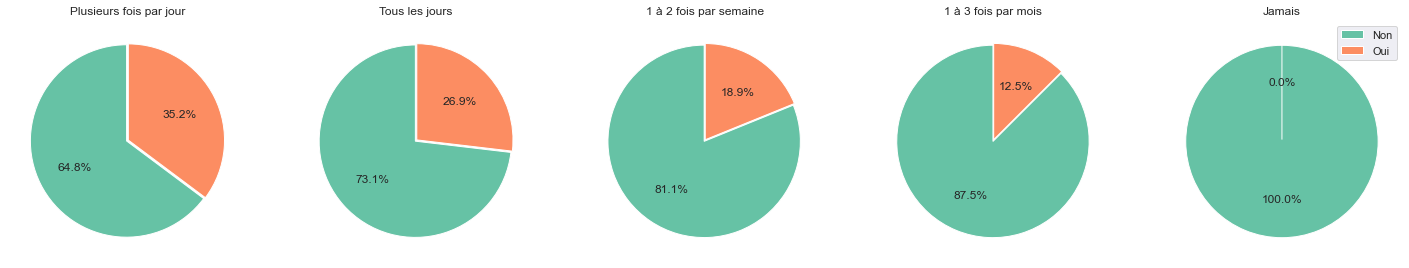

In [51]:
#@title
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

dct = {'Plusieurs fois par jour': 0, 'Tous les jours': 1, '1 à 2 fois par semaine': 2, '1 à 3 fois par mois': 3, 'Jamais': 4}

labels = df[share_content].dropna().value_counts().index.tolist()
explode = (0.01, 0.01)
colors = ['#66c2a5','#fc8d62']

for frequency in df[play_frequency].unique().tolist():
  sizes = df[df[play_frequency]== frequency][share_content].value_counts().tolist()

  if frequency in dct.keys():
    ax[dct[frequency]].set_title(frequency)
    ax[dct[frequency]].pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90);

ax[4].legend(labels, loc='upper right');

In [52]:
#@title
print('Hypothesis (H0): no relation between gaming frequency and sharing content online\n')
stat_test_chi2(df, play_frequency, share_content, 0.05)

Hypothesis (H0): no relation between gaming frequency and sharing content online

+-----------------+--------------------------+-----------------------+----------+---------------------------+------------------+
| share_content   |   1 à 2 fois par semaine |   1 à 3 fois par mois |   Jamais |   Plusieurs fois par jour |   Tous les jours |
|-----------------+--------------------------+-----------------------+----------+---------------------------+------------------|
| Non             |                      228 |                    56 |        7 |                        92 |              343 |
| Oui             |                       53 |                     8 |        0 |                        50 |              126 |
+-----------------+--------------------------+-----------------------+----------+---------------------------+------------------+ 

p value is 0.00018

Conclusion: Dependent (reject H0)



## Categories de jeux auxquels nos target jouent


Targets are people who play sometimes, often, very often or always with people outside their friend group, or share gaming content
Targets represent 466 out of 971 answers
Average number of games selected per target : 3.875536480686695
Average number of games selected per person : 1.8599382080329556


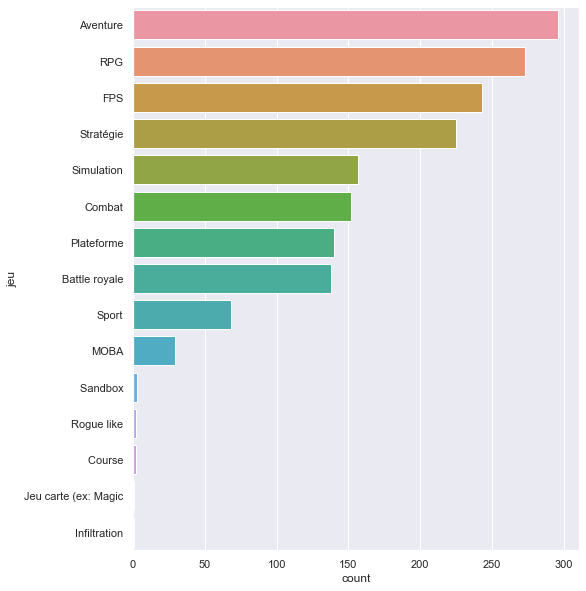

In [53]:
#cleaner categories de jeux
#@title

#limit to targets
test = df[(df[play_outside_friend_group]=='Souvent')|(df[play_outside_friend_group]=='Très souvent')|(df[play_outside_friend_group]=='Parfois')|(df[play_outside_friend_group]=='Toujours')|(df[share_content]=='Oui')]
nb = test.shape[0]
#split games in different columns
new = test[game_types].str.split(",", n = 0, expand = True)

#number of answers in total
nb_answ=df[game_types].str.split(",", n = 0, expand = True) 
z2=[]
for i in new.index:
  for j in new:
    a=nb_answ[j][i]
    z2.append(a)
z2=list(filter(lambda a: a != None, z2))
ser_tot = pd.DataFrame(data=z2, columns = ['jeu']) 

#clean data
for i in new:
  new.loc[new[i].str.contains('rpg', case=False, na=False), i] = 'RPG'
  new.loc[new[i].str.contains('moba', case=False, na=False), i] = 'MOBA'
  new.loc[new[i].str.contains('MMORPGs', case=False, na=False), i] = 'MMORPGs'
  new.loc[new[i].str.contains('sport', case=False, na=False), i] = 'Sport'
  new.loc[new[i].str.contains('combat', case=False, na=False), i] = 'Combat'
  new.loc[new[i].str.contains('fps', case=False, na=False), i] = 'FPS'
  new.loc[new[i].str.contains('aventure', case=False, na=False), i] = 'Aventure'
  new.loc[new[i].str.contains('stratégie', case=False, na=False), i] = 'Stratégie'
  new.loc[new[i].str.contains('simulation', case=False, na=False), i] = 'Simulation'
  new.loc[new[i].str.contains('battle', case=False, na=False), i] = 'Battle royale'

#count values of games
z=[]
for i in new.index:
  for j in new:
    a=new[j][i]
    z.append(a)
z=list(filter(lambda a: a != None, z))
ser = pd.DataFrame(data=z, columns = ['jeu']) 

#plot
plt.figure(figsize=(8,10))
sns.countplot(y=ser['jeu'], order=ser['jeu'].value_counts().iloc[:15].index);

print("Targets are people who play sometimes, often, very often or always with people outside their friend group, or share gaming content")
print("Targets represent "+str(nb)+" out of "+str(ans_cnt)+" answers")
print("Average number of games selected per target : "+ str(ser.shape[0]/nb))
print("Average number of games selected per person : "+ str(ser_tot.shape[0]/ans_cnt))

## **Problèmes des gamers (with Natural Language Processing**

Souhaitez-vous partager avec nous des problèmes que vous rencontrez et qui sont associés aux jeux vidéo 

In [54]:
french_sw = get_stop_words('french')
french_sw.extend(['jeux', 'vidéo', 'vidéos', 'test_token', 'jouer', "n'est", 'non'])
stopwords_french = set(french_sw)

df['test_token'] = df[problems_gamers].dropna().apply(word_tokenize)
df['test_token'] = df['test_token'].dropna().apply(lambda x: [w for w in x if not w.upper() in (e.upper() for e in stopwords_french)])



In [55]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(df['test_token'].dropna()))

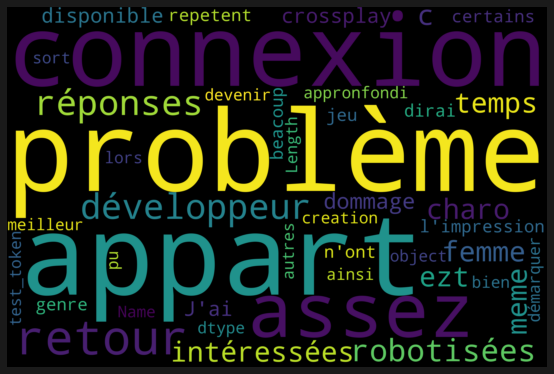

In [56]:
fig = plt.figure(
    figsize = (12, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## **Conclusion**

-75% des joueurs n'ont parfois personne avec qui jouer

-75% des sujets joue une fois par jour au moins

-Les joueurs jouant : (Parfois + Souvent + Très souvent + Toujours) ~=38% avec des gens qu'ils ne connaissent pas IRL. (68% si on compte Rarement). Dépendance avec: le sexe et la fréquence de jeu.

-75% des joueurs n'utilisent pas de services pour trouver des gens avec qui jouer. Dépendance avec: le sexe, la fréquence de jeu et la compétitivité des joueurs.

-71% des joueurs cherchent à s'améliorer. Dépendance avec: le sexe et la fréquence de jeu.

-14% des sujets ont déjà investi de l'argent afin de s'améliorer aux jeux vidéos. Dépendance avec: la fréquence de jeu. (14% de 37 millions de gameurs en France: 5.18 millions de personnes potentielles)

-75% des joueurs n'ont jamais partagé de contenu gaming. Dépendance avec: la fréquence de jeu.

--> CIBLES: principalement homme, entre 18 et 28 ans, étudiants ou jeunes actifs, qui jouent (très) régulièrement à plusieurs jeux vidéos

--> FONCTIONNALITES: 

RECHERCHE DE GROUPE:

-Avantages: Faible complexité, fort potentiel de cibles

-Inconvénients: Les utilisateurs ne l'utiliseront pas de façon régulière ou récurrente


RESEAU SOCIAL:

-Avantages: Fonctionnalité que les utilisateurs vont utiliser régulièrement,  facile a diversifier et monétiser

-Inconvénients: Complexité de développement, intérêt non mis en évidence dans l'étude de marché

COACHING:

-Avantages: Fonctionnalité "exotique", qui va attirer des utilisateurs en tant que coach ce qui est bon pour l'appli (// Tinder), possibilité de monétiser facilement

-Inconvénients: Intérêt non évident dans l'étude de marché, peu de gens intéressés en tant que non-coach







